Modified and verified by **Heejoon Moon**
- version: 11.28

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/컴퓨터비전개론_ICPBL_PROJECT

/content/drive/MyDrive/컴퓨터비전개론_ICPBL_PROJECT


## **0. Preprocessing Data**
- concat RGB frames and opticalflow
- transform videos to '.npy' format
  - '.npy' has 5 channels -> RGB (3) and opticalflow ((u, v) -> 2)
  - you can use another opticalflow algorithms

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

def getOpticalFlow(video):
    """Calculate dense optical flow of input video
    Args:
        video: the input video with shape of [frames,height,width,channel]. dtype=np.array
    Returns:
        flows_x: the optical flow at x-axis, with the shape of [frames,height,width,channel]
        flows_y: the optical flow at y-axis, with the shape of [frames,height,width,channel]
    """
    # initialize the list of optical flows
    gray_video = []
    for i in range(len(video)):
        img = cv2.cvtColor(video[i], cv2.COLOR_RGB2GRAY)
        gray_video.append(np.reshape(img, (224, 224, 1)))

    flows = []
    for i in range(0, len(video) - 1):
        # calculate optical flow between each pair of frames
        # use Farneback method to get dense optical flow
        # calcOpticalFlowFarneback(prev, next, flow, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags[, flow]) -> flow
        flow = cv2.calcOpticalFlowFarneback(gray_video[i], gray_video[i + 1], None, 0.5, 3, 15, 3, 5, 1.2,
                                            cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        # subtract the mean in order to eliminate the movement of camera
        flow[..., 0] -= np.mean(flow[..., 0]) # ... means all the other axes
        flow[..., 1] -= np.mean(flow[..., 1]) # 1 means the second axes
        # normalize each component in optical flow
        flow[..., 0] = cv2.normalize(flow[..., 0], None, 0, 255, cv2.NORM_MINMAX)
        flow[..., 1] = cv2.normalize(flow[..., 1], None, 0, 255, cv2.NORM_MINMAX)
        # Add into list
        flows.append(flow)

    # Padding the last frame as empty array
    flows.append(np.zeros((224, 224, 2))) # why? because the last frame has no optical flow

    return np.array(flows, dtype=np.float32) # convert the list to numpy array


def Video2Npy(file_path, resize=(224,224)):
    """Load video and tansfer it into .npy format
    Args:
        file_path: the path of video file
        resize: the target resolution of output video
    Returns:
        frames: gray-scale video
        flows: magnitude video of optical flows
    """
    # Load video
    cap = cv2.VideoCapture(file_path)
    # Get number of frames
    len_frames = int(cap.get(7))
    # Extract frames from video
    try:
        frames = []
        for i in range(len_frames-1):
            _, frame = cap.read() # cap.read() 은 ret, frame 두 개의 값을 반환한다. ret은 frame을 제대로 읽었는지를 확인하는 boolean 값이고, frame은 읽어온 frame을 반환한다.
            frame = cv2.resize(frame,resize, interpolation=cv2.INTER_AREA) # cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]]) -> dst
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = np.reshape(frame, (224,224,3))
            frames.append(frame)
    except:
        print("Error: ", file_path, len_frames,i)
    finally: # finally는 예외 발생 여부와 상관없이 항상 실행
        frames = np.array(frames)
        cap.release() # cap.release()는 cap.open()으로 열린 캡쳐 객체를 해제

    # Get the optical flow of video
    flows = getOpticalFlow(frames)

    # Visualize optical flow map
    optical_flow_map = farneback_visual(flows)

    result = np.zeros((len(flows),224,224,5)) # 3 for RGB, 2 for optical flows
    result[...,:3] = frames
    result[...,3:] = flows

    return result

def farneback_visual(flows, save_path='farneback_optical_flow.mp4', fps=20):
    # 옵티컬 플로우 데이터를 시각화하는 함수

    # 비디오 라이터 초기화
    h, w = flows[0].shape[:2]
    out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

    for flow in flows:
        # 옵티컬 플로우의 x, y 컴포넌트 분리
        flow_x, flow_y = flow[..., 0], flow[..., 1]

        # 방향과 크기 계산
        magnitude, angle = cv2.cartToPolar(flow_x, flow_y)

        # HSV로 변환
        hsv = np.zeros((h, w, 3), dtype=np.uint8)
        hsv[..., 0] = angle * 180 / np.pi / 2  # Hue 값은 방향에 따라 결정
        hsv[..., 1] = 255  # Saturation을 최대로 설정
        hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)  # Value는 크기에 따라 결정

        # BGR 형식으로 변환
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        # 비디오에 프레임 쓰기
        out.write(bgr)

    # 비디오 라이터 해제
    out.release()


def Save2Npy(file_dir, save_dir):   # modify this code to save the npy files for your directory or path
    """Transfer all the videos and save them into specified directory
    Args:
        file_dir: source folder of target videos
        save_dir: destination folder of output .npy files
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # List the files
    videos = os.listdir(file_dir)
    for v in tqdm(videos):
        # Split video name
        video_name = v.split('.')[0]
        # Get src
        video_path = os.path.join(file_dir, v)
        # Get dest
        save_path = os.path.join(save_dir, video_name+'.npy')
        # Load and preprocess video
        data = Video2Npy(file_path=video_path, resize=(224,224))
        data = np.uint8(data)
        # Save as .npy file
        np.save(save_path, data)

    return None

### convert data and save it (offline)

In [ ]:
'''source_path = 'RWF-2000 Dataset'
target_path = 'npy_dataset'

for f1 in ['train', 'val']:
    for f2 in ['Fight', 'NonFight']:
        path1 = os.path.join(source_path, f1, f2)
        path2 = os.path.join(target_path, f1, f2)
        Save2Npy(file_dir=path1, save_dir=path2)'''

"source_path = 'RWF-2000 Dataset'\ntarget_path = 'npy_dataset'\n\nfor f1 in ['train', 'val']:\n    for f2 in ['Fight', 'NonFight']:\n        path1 = os.path.join(source_path, f1, f2)\n        path2 = os.path.join(target_path, f1, f2)\n        Save2Npy(file_dir=path1, save_dir=path2)"

## **1. Build Data Loader**

In [4]:
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import cv2

class DataGenerator(Dataset):

    ### basic function templates for Dataset class in Pytorch : __init__, __len__, __getitem__###
    def __init__(self, directory, batch_size=1, data_augmentation=True, phase='train'):
        self.batch_size = batch_size
        self.phase=phase # train or val, phase is used to select directory
        self.directory = directory
        self.data_aug = data_augmentation
        self.X_path, self.Y_dict = self.search_data() # get data path and labels
        self.print_stats()

    def __len__(self):
        steps_per_epoch = np.ceil(len(self.X_path) / float(self.batch_size))
        return int(steps_per_epoch)

    # get data and label corresponding to index using 'data_generation function'
    def __getitem__(self, index):
        # get the indexs of each batch
        batch_indexs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # using batch_indexs to get path of current batch
        batch_path = [self.X_path[k] for k in batch_indexs]
        data, label = self.data_generation(batch_path)
        return data.float(), label

    #############################################################
    # -----------------codes down from this line are provided.------------------- #
    # call raw data using data path, and data processing including 'uniform sampling', 'color jittering', 'random flip', and 'normalize'
    #############################################################

    def load_data(self, path):
        # 경로 확인 로그
        data = np.load(path, mmap_mode='r',allow_pickle=True) # Read the raw data from path
        data = self.uniform_sampling(data, target_frames=64) # Randomly sample number of target frames
        if self.data_aug: # If data is augmented...
            data[..., :3] = self.color_jitter(data[..., :3])
            data = self.random_flip(data, prob=0.5) # Random flip image into random direction
        data[..., :3] = self.normalize(data[..., :3]) # Normalize RGB
        data[..., 3:] = self.normalize(data[..., 3:]) # Normalize optical flows
        return data

    # shuffle data
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    # Normalize data
    def normalize(self, data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std

    def random_flip(self, video, prob):
        s = np.random.rand()
        if s < prob:
            video = np.flip(video, (2,)) # Flip in width direction
        return video

    # Randomly sample number of target frames
    def uniform_sampling(self, video, target_frames=64):
        # get total frames of input video and calculate sampling interval
        len_frames = int(len(video))
        interval = int(np.ceil(len_frames/target_frames))
        # init empty list for sampled video and
        sampled_video = []
        for i in range(0,len_frames,interval):
            sampled_video.append(video[i])
        # calculate number of padded frames and fix it
        num_pad = target_frames - len(sampled_video) # num pad = # target frame - # current frame
        padding = []
        if num_pad>0:
            for i in range(-num_pad,0):
                try:
                    padding.append(video[i]) # Fill with the last video frame
                except:
                    padding.append(video[0])
            sampled_video += padding # Add padding results
        # get sampled video
        return np.array(sampled_video, dtype=np.float32)

    # Jitter = spread values (랜덤 노이즈를 추가하여 데이터를 늘림)
    def color_jitter(self, video):
        s_jitter = np.random.uniform(-0.2, 0.2)
        v_jitter = np.random.uniform(-30, 30)
        for i in range(len(video)): # hsv: hue, saturation, value
            hsv = cv2.cvtColor(np.array(video[i]), cv2.COLOR_RGB2HSV) # Convert RGB -> HSV
            s = hsv[..., 1] + s_jitter # saturation jitter
            v = hsv[..., 2] + v_jitter # Value jitter
            # Flip
            s[s < 0] = 0
            s[s > 1] = 1
            v[v < 0] = 0
            v[v > 255] = 255
            hsv[..., 1] = s # set jittered saturation
            hsv[..., 2] = v # Set jittered value
            video[i] = torch.Tensor(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)) # Convert HSV -> RGB again
        return video

    # print current state of the Dataset class
    def print_stats(self):
            self.n_files = len(self.X_path)
            self.n_classes = len(self.dirs)
            self.indexes = np.arange(len(self.X_path))
            np.random.shuffle(self.indexes)
            print("Found {} files belonging to {} classes.".format(self.n_files, self.n_classes))
            for i, label in enumerate(self.dirs):
                print('{:10s} : {}'.format(label, i))

    #############################################################
    # Fill the missing part of the code with functions given above
    #############################################################

    # get data and label(one-hot encoded) from path list/dictionary
    def search_data(self):
        X_path = []
        Y_dict = {}
        self.dirs = sorted(os.listdir(self.directory)) # Get sorted file directories
        one_hots = np.eye(len(self.dirs)) ###Fill here###  # One-hot encoded vector
        for i, folder in enumerate(self.dirs):
            folder_path = os.path.join(self.directory, folder) # Get path
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file) # Get path
                X_path.append(file_path) # Add path to X_path
                Y_dict[file_path] = one_hots[i] # Add one-hot encoded vector to Y_dict

                # Load the data safely

        return X_path, Y_dict

    # define batch x using 'load_data' function and batch_y from self.Y_dict.
    ### fill here ###
    def data_generation(self, batch_path):
        batch_x = np.array([self.load_data(path) for path in batch_path])
        batch_y = np.array([self.Y_dict[path] for path in batch_path])
        # NumPy 배열을 PyTorch 텐서로 변환
        batch_x = torch.Tensor(batch_x)
        batch_y = torch.Tensor(batch_y)

        return batch_x, batch_y

## **2. Build Simple Model**
- this model is 'Flow Gated Network' proposed in 'RWF2000'
- you can use off-the-shelf architectures such as ResNet, EfficientNet, etc.
- model structure is produced in below image
- Fully-Connected layer is little bit different with image, so we provide Fully-Connected layer structure

![image.png](attachment:image.png)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        self.relu=nn.ReLU(inplace=True)

        ## Hint: Please refer to above table for constructing layers
        # Construct block of RGB layers which takes RGB channel(3) as input
        # nn.Conv3D(input_channel, output_channel, kernel_size, padding)
        ########  rgb  #########
        self.rgb_block1 = nn.Sequential(
            nn.Conv3d(3, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )
        self.rgb_block2 = nn.Sequential(
            nn.Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )
        self.rgb_block3 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )
        self.rgb_block4 = nn.Sequential(
            nn.Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )

        # Construct block of optical flow layers which takes the optical flow channel(2) as input
        ######## opt  #########
        self.opt_block1 = nn.Sequential(
            nn.Conv3d(2, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )
        self.opt_block2 = nn.Sequential(
            nn.Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )
        self.opt_block3 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )
        self.opt_block4 = nn.Sequential(
            nn.Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )

        # Construct merging Block
        ######## merge  #########
        self.merge_block1 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2))
        )
        self.merge_block2 = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2))
        )
        self.merge_block3 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2))
        )
        ##########################################
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=2, batch_first=True)
        self.fc_lstm = nn.Linear(64, 2)
        #########################################
        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 2)

        # Initialize weights
        self.__init_weight()

    def forward(self, x):
        #print("")
        #print("Initial shape:", x.shape)
        x = x.transpose(2,4)
        x = x.transpose(3,4)
        x = x.transpose(1,2)
        rgb = x[:,:3,:,:,:]
        opt = x[:,3:5,:,:,:]
        #print("After splitting RGB and Optical Flow, shape:", rgb.shape, opt.shape)
        # Pass through the RGB data through the blocks of RGB layers
        rgb = self.rgb_block1(rgb)
        rgb = self.rgb_block2(rgb)
        rgb = self.rgb_block3(rgb)
        rgb = self.rgb_block4(rgb)
        # Pass through the optical flow data through the blocks of RGB layers
        opt = self.opt_block1(opt)
        opt = self.opt_block2(opt)
        opt = self.opt_block3(opt)
        opt = self.opt_block4(opt)
        # Fuse by performing elementwise multiplication of rgb and opt tensors.
        fused = rgb * opt ## fill here ##
        # Perform maxpooling of fused
        fused = F.max_pool3d(fused, kernel_size=(8, 1, 1)) ## fill here ##

        # Pass through the fused data into merging block
        merged = self.merge_block1(fused)
        merged = self.merge_block2(merged)
        merged = self.merge_block3(merged)
 ###############################
        x = merged.view(merged.size(0), -1, 128)  # adjusting LSTM size
        x, _ = self.lstm(x)
        x = self.fc_lstm(x[:, -1, :])
 ###############################
        # Fully Connected Layers
        x = merged.view(merged.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                # Perform weight initialization ("kaiming normal")
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


## **3. Training the Model**
- set hyper-parameters for training

In [8]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm
import wandb


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define model, optimizer and criterion
model = FusionModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.003, weight_decay=1e-6, momentum=0.9, nesterov=True)
loss_fn = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

trainset_path = './npy_dataset/train'
validation_path = './npy_dataset/val'

# define dataset and dataloader
train_dataset = DataGenerator(trainset_path, data_augmentation=True, phase='train')
val_dataset = DataGenerator(validation_path, data_augmentation=False, phase='val')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

# epoch = 30
# learning rate = 0.003

# optimizer = SGD
# weight decay = 1e-6
# momentum = 0.9
# nesterov = True
# gamma = 0.7

# loss = CrossEntropy

# assign device cpu or gpu
min_loss = np.inf


Found 160 files belonging to 2 classes.
Fight      : 0
NonFight   : 1
Found 40 files belonging to 2 classes.
Fight      : 0
NonFight   : 1


In [ ]:
def _train(train_loader, model, optimizer, loss_fn, scheduler):
    model.train()
    acc_temp = 0
    running_loss = 0

    # forward propagation and backpropagation
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="Training Epoch {}".format(epoch))):
        #print('data shape:',data.shape)
        data, target = data.squeeze(1).to(device), target.squeeze().to(device)
        #print('data shape:',data.shape)
        optimizer.zero_grad() # initialize gradient as zero
        output = model(data)
         # forward propagation
        loss = loss_fn(output, target.view(1, -1))
        #loss = loss_fn(output, target) # calculate loss
        loss.backward() # backpropagation
        optimizer.step() # update parameters
        running_loss += loss.item() # accumulate loss
        pred = output.argmax(dim=-1, keepdim=True)
        acc_temp += pred.eq(target.argmax(dim=-1)).sum().item()

    # calculate accuracy and loss on training set
    train_acc = acc_temp / len(train_loader.dataset)
    train_loss = running_loss / len(train_loader.dataset)
    return train_acc, train_loss

In [ ]:
def _val(val_loader, model, loss_fn):
    model.eval()
    with torch.no_grad():
        running_loss_val = 0
        acc_temp_val =0
        for batch_idx, (data, target) in enumerate(tqdm(val_loader, desc="Validation Epoch {}".format(epoch))):
            data, target = data.squeeze(1).to(device), target.squeeze().to(device)
            output = model(data)
            # forward propagation
            loss = loss_fn(output, target.view(1, -1))
            running_loss_val += loss.item()
            pred = output.argmax(dim=-1, keepdim=True) #
            acc_temp_val += pred.eq(target.argmax(dim=-1)).sum().item()

        # calculate accuracy and loss on validation set
        val_acc = acc_temp_val / len(val_loader.dataset)
        val_loss = running_loss_val / len(val_loader.dataset)
    return val_acc, val_loss

In [ ]:
import random
import numpy as np
from tqdm import tqdm

seed=0
random.seed(seed)
np.random.seed(seed)
device='cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)
if device =='cuda':
    print('gpu device is using')
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

wandb.login()
wandb.init(project='computer vision', name='test')

epoch = 30
for epoch in range(epoch):
    # Perform training and validation
    # Save the weights
    # Log the training and validation results
    # Save the best model weights
    train_acc, train_loss = _train(train_loader, model, optimizer, loss_fn, scheduler)
    val_acc, val_loss = _val(val_loader, model, loss_fn)

    print(f"Epoch:{epoch} => train_acc:",train_acc,"train_loss:", train_loss, "val_acc:", val_acc, "val_loss:", val_loss)
    scheduler.step() # update learning rate
    wandb.log({'train_acc': train_acc, 'train_loss': train_loss, 'val_acc': val_acc, 'val_loss': val_loss})
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model.state_dict(), 'test.pth')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


gpu device is using


Validation Epoch 0: 100%|██████████| 40/40 [00:05<00:00,  7.26it/s]


Epoch:0 => train_acc: 0.53125 train_loss: 0.6981409654021263 val_acc: 0.5 val_loss: 0.685123334825039


Validation Epoch 1: 100%|██████████| 40/40 [00:05<00:00,  6.87it/s]


Epoch:1 => train_acc: 0.5875 train_loss: 0.6837037021294237 val_acc: 0.525 val_loss: 0.6696062579751014


Validation Epoch 2: 100%|██████████| 40/40 [00:05<00:00,  7.33it/s]


Epoch:2 => train_acc: 0.65625 train_loss: 0.6416014056652785 val_acc: 0.675 val_loss: 0.576045797765255


Validation Epoch 3: 100%|██████████| 40/40 [00:05<00:00,  6.93it/s]


Epoch:3 => train_acc: 0.6625 train_loss: 0.6124124946072698 val_acc: 0.85 val_loss: 0.5625708259642124


Validation Epoch 4: 100%|██████████| 40/40 [00:05<00:00,  7.44it/s]


Epoch:4 => train_acc: 0.6625 train_loss: 0.6361181998392567 val_acc: 0.625 val_loss: 0.6249467588961124


Validation Epoch 5: 100%|██████████| 40/40 [00:05<00:00,  6.91it/s]


Epoch:5 => train_acc: 0.74375 train_loss: 0.5714020425453782 val_acc: 0.675 val_loss: 0.572658556420356


Validation Epoch 6: 100%|██████████| 40/40 [00:05<00:00,  7.30it/s]


Epoch:6 => train_acc: 0.75 train_loss: 0.5511248488677666 val_acc: 0.925 val_loss: 0.48885950110852716


Validation Epoch 7: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s]


Epoch:7 => train_acc: 0.7875 train_loss: 0.5041640726078185 val_acc: 0.8 val_loss: 0.5128698863089085


Validation Epoch 8: 100%|██████████| 40/40 [00:05<00:00,  7.04it/s]


Epoch:8 => train_acc: 0.74375 train_loss: 0.5183410569676198 val_acc: 0.925 val_loss: 0.45020448612049224


Validation Epoch 9: 100%|██████████| 40/40 [00:05<00:00,  6.68it/s]


Epoch:9 => train_acc: 0.79375 train_loss: 0.47378356780827746 val_acc: 0.9 val_loss: 0.45509149245917796


Validation Epoch 10: 100%|██████████| 40/40 [00:05<00:00,  7.18it/s]


Epoch:10 => train_acc: 0.80625 train_loss: 0.4783797742886236 val_acc: 0.875 val_loss: 0.4385462742298841


Validation Epoch 11: 100%|██████████| 40/40 [00:06<00:00,  6.47it/s]


Epoch:11 => train_acc: 0.78125 train_loss: 0.4721172339108307 val_acc: 0.925 val_loss: 0.4348723812960088


Validation Epoch 12: 100%|██████████| 40/40 [00:05<00:00,  7.16it/s]


Epoch:12 => train_acc: 0.78125 train_loss: 0.48095107855115204 val_acc: 0.925 val_loss: 0.4333185564726591


Validation Epoch 13: 100%|██████████| 40/40 [00:05<00:00,  6.83it/s]


Epoch:13 => train_acc: 0.78125 train_loss: 0.4660845506368787 val_acc: 0.925 val_loss: 0.43097747694700955


Validation Epoch 14: 100%|██████████| 40/40 [00:05<00:00,  7.45it/s]


Epoch:14 => train_acc: 0.775 train_loss: 0.45947079599027346 val_acc: 0.925 val_loss: 0.4317188382148743


Validation Epoch 15: 100%|██████████| 40/40 [00:05<00:00,  6.83it/s]


Epoch:15 => train_acc: 0.80625 train_loss: 0.45354507528536486 val_acc: 0.925 val_loss: 0.4294294406659901


Validation Epoch 16: 100%|██████████| 40/40 [00:05<00:00,  7.21it/s]


Epoch:16 => train_acc: 0.79375 train_loss: 0.4491074024052068 val_acc: 0.925 val_loss: 0.4282149730250239


Validation Epoch 17: 100%|██████████| 40/40 [00:05<00:00,  6.87it/s]


Epoch:17 => train_acc: 0.80625 train_loss: 0.4494572833773418 val_acc: 0.925 val_loss: 0.4280749199911952


Validation Epoch 18: 100%|██████████| 40/40 [00:05<00:00,  7.47it/s]


Epoch:18 => train_acc: 0.79375 train_loss: 0.45197465888795707 val_acc: 0.925 val_loss: 0.4279350556433201


Validation Epoch 19: 100%|██████████| 40/40 [00:05<00:00,  6.88it/s]


Epoch:19 => train_acc: 0.7875 train_loss: 0.4642941599675396 val_acc: 0.925 val_loss: 0.4280829379335046


Validation Epoch 20: 100%|██████████| 40/40 [00:05<00:00,  7.17it/s]


Epoch:20 => train_acc: 0.8 train_loss: 0.46086341560585425 val_acc: 0.925 val_loss: 0.4278380053117871


Validation Epoch 21: 100%|██████████| 40/40 [00:05<00:00,  6.91it/s]


Epoch:21 => train_acc: 0.80625 train_loss: 0.4600501452609024 val_acc: 0.925 val_loss: 0.42763600442558525


Validation Epoch 22: 100%|██████████| 40/40 [00:05<00:00,  7.19it/s]


Epoch:22 => train_acc: 0.8 train_loss: 0.4547151445207419 val_acc: 0.925 val_loss: 0.4276684241369367


Validation Epoch 23: 100%|██████████| 40/40 [00:05<00:00,  7.09it/s]


Epoch:23 => train_acc: 0.79375 train_loss: 0.46862694089650175 val_acc: 0.925 val_loss: 0.4276045429520309


Validation Epoch 24: 100%|██████████| 40/40 [00:05<00:00,  7.21it/s]


Epoch:24 => train_acc: 0.775 train_loss: 0.46495520589596706 val_acc: 0.925 val_loss: 0.4276101216673851


Validation Epoch 25: 100%|██████████| 40/40 [00:06<00:00,  6.62it/s]


Epoch:25 => train_acc: 0.79375 train_loss: 0.44889790460583756 val_acc: 0.925 val_loss: 0.4275831234641373


Validation Epoch 26: 100%|██████████| 40/40 [00:05<00:00,  6.95it/s]


Epoch:26 => train_acc: 0.7875 train_loss: 0.4566981909010792 val_acc: 0.925 val_loss: 0.4275686252862215


Validation Epoch 27: 100%|██████████| 40/40 [00:05<00:00,  7.03it/s]


Epoch:27 => train_acc: 0.79375 train_loss: 0.4543335605303582 val_acc: 0.925 val_loss: 0.4275747459381819


Validation Epoch 28: 100%|██████████| 40/40 [00:05<00:00,  6.97it/s]


Epoch:28 => train_acc: 0.8 train_loss: 0.4666044135719858 val_acc: 0.925 val_loss: 0.4275765690021217


Validation Epoch 29: 100%|██████████| 40/40 [00:05<00:00,  7.10it/s]

Epoch:29 => train_acc: 0.7875 train_loss: 0.46576269136312476 val_acc: 0.925 val_loss: 0.4275834963656962


In [6]:
best_model = './test.pth'
test_path = './data/npy_dataset_sampled_10/test'

test_dataset = DataGenerator(directory=test_path, data_augmentation=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)

Found 20 files belonging to 2 classes.
Fight      : 0
NonFight   : 1


Test: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Test AUROC: 0.8


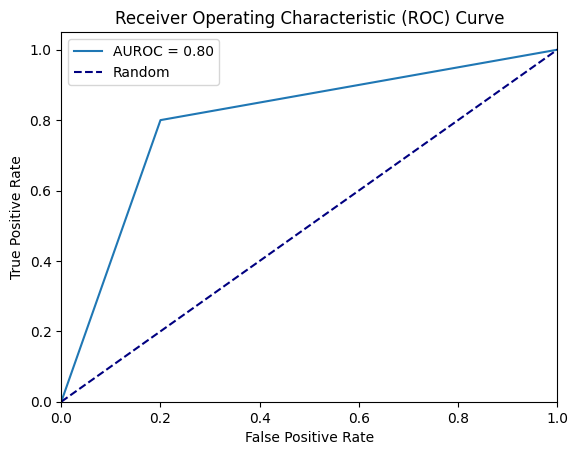

In [9]:
### AUROC PLOT ###
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model.load_state_dict(torch.load(best_model))
model.eval()
y_true = []
y_score = []
running_loss_test = 0
acc_temp_test =0
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader, desc="Test")):
        data, target = data.squeeze(0).to(device), target.squeeze().to(device)
        # print(target)
        output = model(data).squeeze()
        loss = loss_fn(output, target)
        running_loss_test += loss.item()
        y_true.extend(target.cpu().numpy())
        pred_idx = output.argmax(dim=-1, keepdim=True).squeeze()
        pred = torch.zeros(output.shape).to(device)
        pred[pred_idx] = 1.
        y_score.extend(pred.cpu().numpy())
        acc_temp_test += pred.eq(target.argmax(dim=-1)).sum().item()

# AUROC 계산
auroc = roc_auc_score(y_true,y_score)
print(f'Test AUROC: {auroc}')

# ROC curve plot
fpr, tpr, _ = roc_curve(y_true,y_score)
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="upper left")
plt.show()

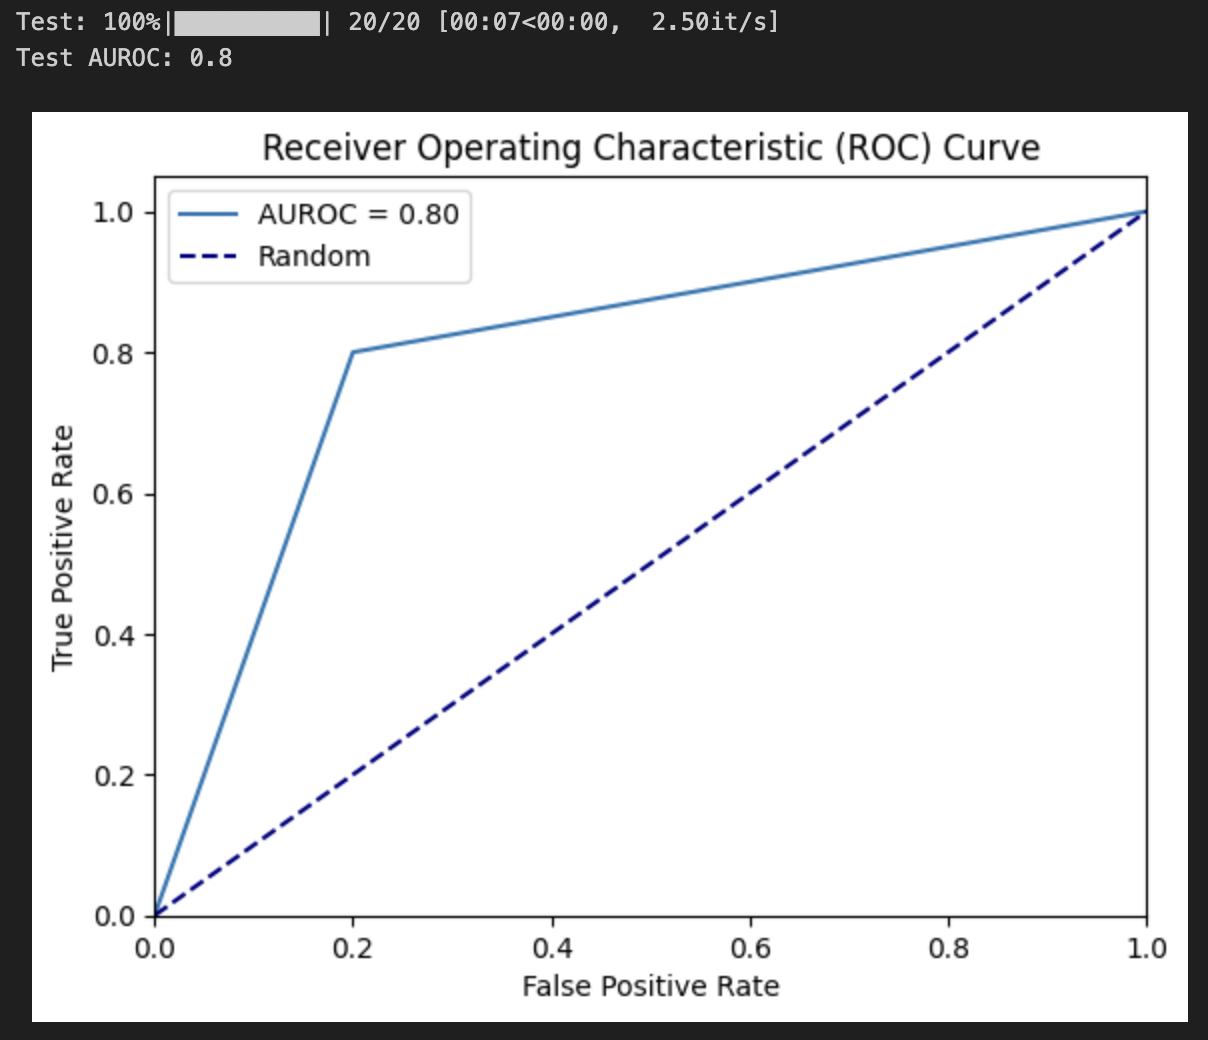